In [1]:
%cd "~/code/dsi/capstone_1"

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sys.path.insert(0, '..')
from scripts.helper_functions import ecdf, bootstrap_confidence_interval, bootstrap

plt.style.use('ggplot')

lic_data = pd.read_csv('data/licensees_year_Nonemonth_None.csv/part-00000-e336c06b-db61-472c-8357-de32b6d8a4df-c000.csv')
lab_data = pd.read_csv('data/lab_results_all')

/home/austin/code/dsi/capstone_1


In [2]:
lic_data.head()

,global_id,created_at,external_id,name,type
0,WAWA1.MM1,1900-01-01T00:00:00.000-08:00,1,WA State,state
1,WAWA1.MM2,1900-01-01T00:00:00.000-08:00,1111,LCB Grow,cultivator
2,WAWA1.MM3,1900-01-01T00:00:00.000-08:00,2222,LCB Mfg,production
3,WAWA1.MM4,1900-01-01T00:00:00.000-08:00,3333,LCB Retail,dispensary
4,WAWA1.MM5,1900-01-01T00:00:00.000-08:00,4444,LCB Lab,lab


In [3]:
lic_data[lic_data['global_id'] == 'WAWA1.MM1L5']

,global_id,created_at,external_id,name,type
1912,WAWA1.MM1L5,1900-01-01T00:00:00.000-08:00,22,Integrity Labs,lab


In [4]:
lab_data.head()

,Unnamed: 0,global_id,created_at,mme_id,user_id,external_id,inventory_id,updated_at,status,testing_status,batch_id,for_mme_id,lab_user_id,type,cannabinoid_status,cannabinoid_editor,cannabinoid_d9_thc_percent,cannabinoid_cbd_percent,cannabinoid_cbda_percent
0,0,WAL20.LR13GJS,2020-01-01 05:33:50,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 001,WAL20.INFMAK8,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM6,WAWA1.MMD8,WAWA1.US2VM,harvest_materials,completed,NaN,0.465,0.0,0.0
1,1,WAL20.LR13GJT,2020-01-01 05:33:51,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 002,WAL20.INFMAK9,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM7,WAWA1.MMD8,WAWA1.US2VM,intermediate_product,completed,NaN,18.137,0.0,0.0
2,2,WAL20.LR13GJU,2020-01-01 05:33:51,WAWA1.MM1VC,WAWA1.US2VM,P191227-4 003,WAL20.INFMAKA,2020-01-01 05:33:51,passed,completed,WAL20.BAFRDM8,WAWA1.MMD8,WAWA1.US2VM,end_product,completed,NaN,0.102,0.0,0.0
3,3,WAL3.LR13GJV,2020-01-01 22:13:10,WAWA1.MM1L2,WAWA1.US2IP,NaN,WAL3.INFPXAD,2020-01-03 09:28:50,failed,in_progress,WAL3.BAFUARZ,WAWA1.MMX7,WAWA1.US2IP,marijuana,NaN,NaN,NaN,NaN,NaN
4,4,WAL3.LR13GJW,2020-01-01 22:14:33,WAWA1.MM1L2,WAWA1.US2IP,NaN,WAL3.INFPXAN,2020-01-05 12:20:24,failed,in_progress,WAL3.BAFUASE,WAWA1.MMUT,WAWA1.US2IP,marijuana,NaN,NaN,NaN,NaN,NaN


In [5]:
df = lab_data.merge(lic_data, how='left', left_on='mme_id', right_on='global_id')

df = df.drop(columns=['cannabinoid_cbd_percent', 'user_id', 'inventory_id', 'external_id_x', 'global_id_y'
                      , 'updated_at', 'status', 'testing_status', 'cannabinoid_status', 'external_id_y'
                      , 'cannabinoid_editor', 'lab_user_id','cannabinoid_cbda_percent'])

df = df.merge(lic_data, how='left', left_on='for_mme_id', right_on='global_id')

df = df.drop(columns=['global_id', 'created_at', 'external_id', 'created_at_x', 'created_at_y', 'global_id'])
df = df.iloc[: , 1:] # drops extra index

In [6]:
df = df.rename(columns={'name_x': 'lab_name'
                   , 'type_y': 'lab_business_type'
                   , 'nameglobal_id': 'requester_name'
                   , 'type': 'requester_business_type'
                   , 'name_y': 'requester_name'
                   , 'type_x': 'material_type'
                   , 'global_id_x': 'test_id'})

In [7]:
df.isnull().sum() / len(df)

test_id                       0.00000
mme_id                        0.00000
batch_id                      0.00000
for_mme_id                    0.00000
material_type                 0.00000
cannabinoid_d9_thc_percent    0.06466
lab_name                      0.00000
lab_business_type             0.00000
requester_name                0.00000
requester_business_type       0.00000
dtype: float64

In [8]:
df.dropna(inplace=True)

In [9]:
df.tail()

,test_id,mme_id,batch_id,for_mme_id,material_type,cannabinoid_d9_thc_percent,lab_name,lab_business_type,requester_name,requester_business_type
141126,WAL22.LR16HFY,WAWA1.MM1LF,WAL22.BALUDBD,WAWA1.MME6,intermediate_product,2.75,CAPITOL ANALYSIS,lab,AGRO COUTURE,cultivator_production
141127,WAL22.LR16HFZ,WAWA1.MM1LF,WAL22.BALUFTG,WAWA1.MMV9,intermediate_product,77.92,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production
141128,WAL22.LR16HG0,WAWA1.MM1LF,WAL22.BALUFTH,WAWA1.MMV9,intermediate_product,11.85,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production
141129,WAL22.LR16HG1,WAWA1.MM1LF,WAL22.BALUFTF,WAWA1.MMV9,intermediate_product,1.86,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production
141132,WAL22.LR16HG4,WAWA1.MM1LF,WAL22.BALUFTI,WAWA1.MMV9,intermediate_product,74.34,CAPITOL ANALYSIS,lab,"CANNABIS NORTHWEST C-M, INC",production


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132012 entries, 0 to 141132
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   test_id                     132012 non-null  object 
 1   mme_id                      132012 non-null  object 
 2   batch_id                    132012 non-null  object 
 3   for_mme_id                  132012 non-null  object 
 4   material_type               132012 non-null  object 
 5   cannabinoid_d9_thc_percent  132012 non-null  float64
 6   lab_name                    132012 non-null  object 
 7   lab_business_type           132012 non-null  object 
 8   requester_name              132012 non-null  object 
 9   requester_business_type     132012 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.1+ MB


In [11]:
df['batch_id'].value_counts()

WAL3.BAKBWAO     4
WAL3.BAIT55G     3
WAL18.BAI7AJA    3
WAL3.BAHYGW7     3
WAL3.BAHYGW8     3
                ..
WAL21.BAHT8G2    1
WAL7.BAKPCAF     1
WAL7.BAFYAWP     1
WAL9.BAHDY1N     1
WAL3.BAJBX2K     1
Name: batch_id, Length: 131907, dtype: int64

(array([1.31809e+05, 0.00000e+00, 0.00000e+00, 9.20000e+01, 0.00000e+00,
        0.00000e+00, 5.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

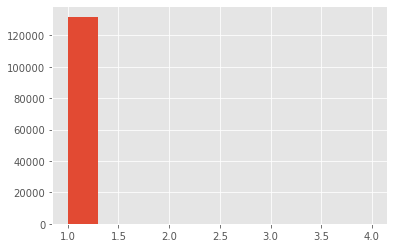

In [12]:
plt.hist(df['batch_id'].value_counts())

In [13]:
df['cannabinoid_d9_thc_percent'].value_counts()

0.600     5851
0.700     5460
0.500     4505
0.800     4486
0.000     4369
          ... 
73.579       1
40.670       1
4.844        1
29.264       1
4.662        1
Name: cannabinoid_d9_thc_percent, Length: 12468, dtype: int64

In [14]:
df['lab_name'].value_counts()

Testing Technologies              25971
Treeline Analytics                25933
Praxis Laboratory                 18661
Confidence Analytics              14101
Green Grower Labs                 13981
Integrity Labs                    12156
CAPITOL ANALYSIS                   6156
True Northwest, Inc.               4320
G.O.A.T. Labs                      4185
Analytical 360, LLC.               3577
Medicine Creek Analytics           1974
Trace Analytics                     808
Dragon Analytical Laboratory        174
Pacific Botanical Laboratories       15
Name: lab_name, dtype: int64

In [15]:
df['requester_name'].value_counts()

GROW OP FARMS                   7080
NORTHWEST CANNABIS SOLUTIONS    2847
NWCS                            2843
PHAT N STICKY                   2817
ROLLING FARMS                   2580
                                ... 
CHESHIRE CREEK                     1
CHINOOK GROWERS                    1
ANDLES INC                         1
THC EXPRESS                        1
EVERGREEN FOREST                   1
Name: requester_name, Length: 705, dtype: int64

In [16]:
df['material_type'].value_counts()

harvest_materials       95869
intermediate_product    27604
end_product              6280
marijuana                2243
mature_plant               16
Name: material_type, dtype: int64

In [17]:
df_by_lab = df.groupby('lab_name')
df_by_requester = df.groupby('requester_name')

''

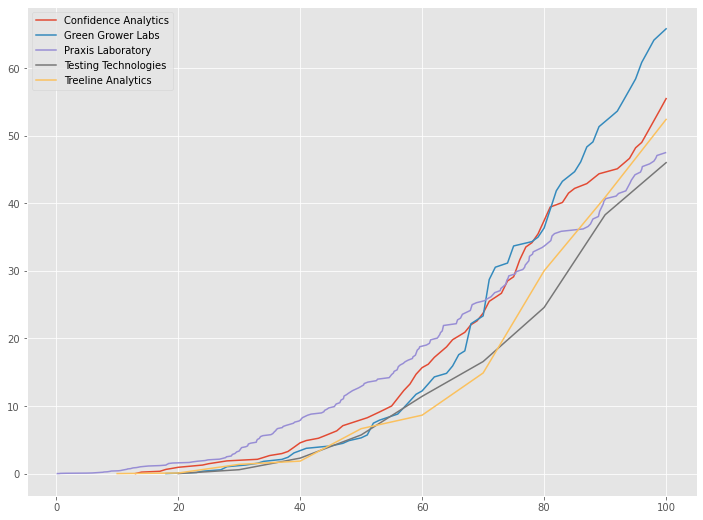

In [18]:
n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,9))


for name, group in df_by_lab:
    
    group = group[group['material_type'] == 'end_product']
    
    if len(group) < 500:
        continue
    
    data = np.array(group['cannabinoid_d9_thc_percent'].values)
    data = data[data <= 1] * 100
    data = data[(data <= 100) & (data != 0)]
    
    #sns.kdeplot(data, label=name, ax=ax)
    x,y = ecdf(data, True)
    ax.plot(x,y, label=name)


ax.legend()
;

/home/austin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/austin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/austin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


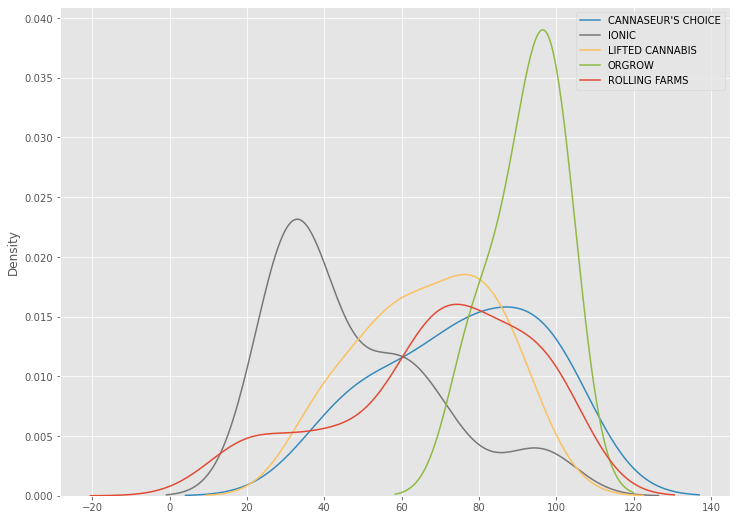

In [19]:
n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,9))


for name, group in df_by_requester:
    if len(group) < 1000:
        continue
    
    group = group[group['material_type'] == 'end_product']
    
    data = np.array(group['cannabinoid_d9_thc_percent'].values)
    data = data[data <= 1] * 100
    data = data[(data <= 100) & (data != 0)]
    
    sns.kdeplot(data, label=name, ax=ax)


ax.legend()

In [20]:
grow_op = df_by_requester.get_group('GROW OP FARMS')
grow_op['lab_name'].value_counts()

Green Grower Labs       4181
Praxis Laboratory       2896
Testing Technologies       3
Name: lab_name, dtype: int64

In [21]:
grow_op_by_lab = grow_op.groupby('lab_name')

In [22]:
df['material_type'].value_counts()

harvest_materials       95869
intermediate_product    27604
end_product              6280
marijuana                2243
mature_plant               16
Name: material_type, dtype: int64

Green Grower Labs 3321
Praxis Laboratory 2101


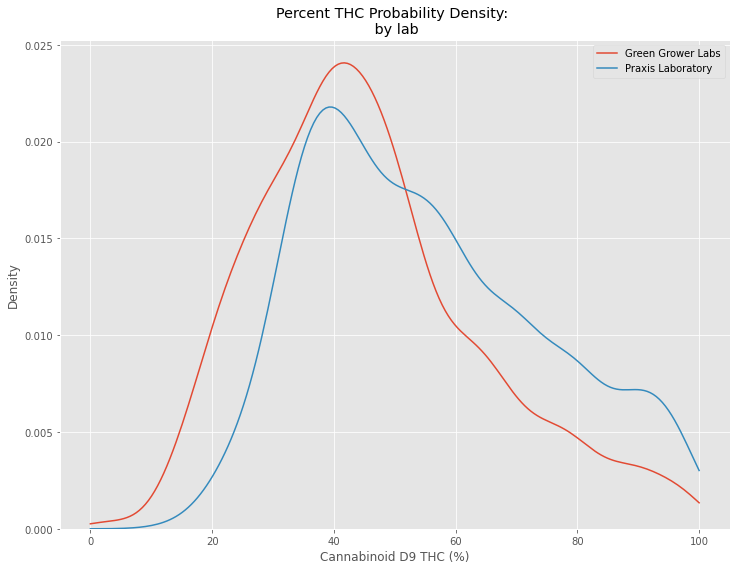

In [23]:
n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,9))


for name, group in grow_op_by_lab:
    group = group[group['material_type'] == 'harvest_materials']
    
    if len(group) < 5:
        continue
    
    data = np.array(group['cannabinoid_d9_thc_percent'].values)
    data = data[data <= 1] * 100
    data = data[(data <= 100) & (data != 0)]
    
    sns.kdeplot(data, label=name, ax=ax, clip=(0,100))
    print(name, len(data))

ax.set_title('Percent THC Probability Density: \n by lab')
ax.set_xlabel('Cannabinoid D9 THC (%)')
ax.legend()

Green Grower Labs 3321
Praxis Laboratory 2101
<class 'matplotlib.legend.Legend'>


/home/austin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/austin/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


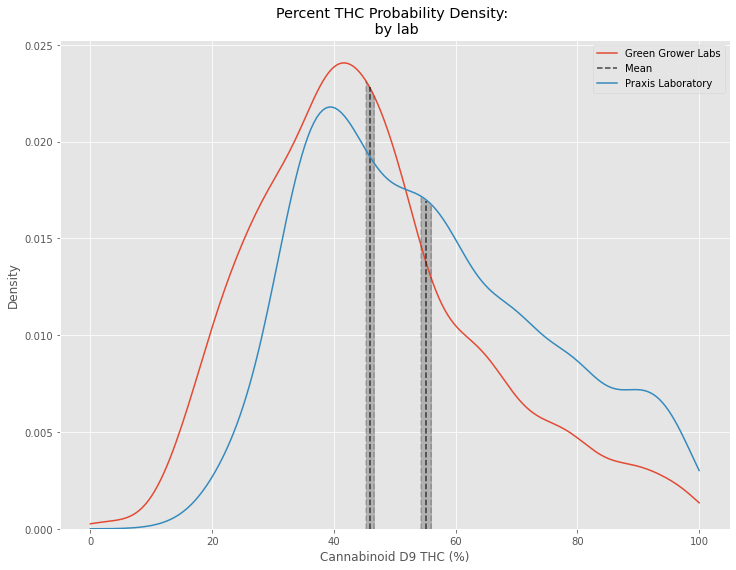

In [59]:
n_rows, n_cols = 1, 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,9))

dict_ = {}
mean_lables = ['Mean w/ 95% CI', '_nolegned_']
i = 0
for name, group in grow_op_by_lab:
    group = group[group['material_type'] == 'harvest_materials']
    
    if len(group) < 5:
        continue
    
    data = np.array(group['cannabinoid_d9_thc_percent'].values)
    data = data[data <= 1] * 100
    data = data[(data <= 100) & (data != 0)]
    #data = stats.boxcox(data, 1) # attempt to find normal model after transform
    
    lower, upper, _ = bootstrap_confidence_interval(data)
    mean = np.mean(data)
    
    dict_[name] = data
    sns.kdeplot(data, label=name, ax=ax, clip=(0,100))
    
    dens = sm.nonparametric.KDEUnivariate(data)
    dens.fit()
    x = np.linspace(lower, upper, 100) #restrict range to (0,100)
    y = dens.evaluate(x)
    
    ax.plot([lower, lower], [0, dens.evaluate(lower)], linestyle='--', alpha=.2, color='black')
    ax.plot([mean, mean], [0, dens.evaluate(mean)], linestyle='--' , alpha=.7, color='black', label=mean_lables[i])
    ax.plot([upper, upper], [0, dens.evaluate(upper)], linestyle='--' , alpha=.2, color='black')

    fill_between_x = np.linspace(lower, upper, 100)
    fill_between_y_0 = np.zeros(100)
    fill_between_y_1 = dens.evaluate(fill_between_x)
    
    ax.fill_between(fill_between_x, fill_between_y_0, fill_between_y_1, color='grey', alpha=.5)
    i += 1
    print(name, len(data))

ax.set_title('Percent THC Probability Density: \n by lab')
ax.set_xlabel('Cannabinoid D9 THC (%)')
ax.legend()

print(type(ax.legend()))

In [25]:
dict_

{'Green Grower Labs': array([80., 73., 72., ..., 34., 43., 37.]),
 'Praxis Laboratory': array([70.7, 64.5, 70. , ..., 65.2, 65.3, 60.1])}

In [26]:
stat, p_val = stats.ttest_ind(dict_['Green Grower Labs']
                              , dict_['Praxis Laboratory']
                              , equal_var=False)
print(stat, p_val)

-17.188313850691397 4.1083955658934735e-64


In [27]:
stats.mannwhitneyu(dict_['Green Grower Labs']
                   , dict_['Praxis Laboratory']
                   , alternative='less')

MannwhitneyuResult(statistic=2559918.0, pvalue=9.3047665441433e-62)

In [28]:
stats.mannwhitneyu(dict_['Praxis Laboratory']
                   , dict_['Green Grower Labs']
                   , alternative='greater')

MannwhitneyuResult(statistic=4417503.0, pvalue=9.3047665441433e-62)

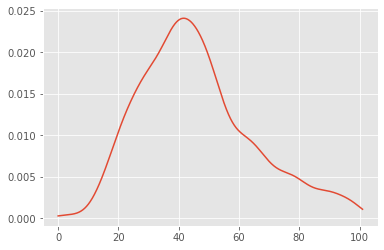

In [36]:
import statsmodels.api as sm

dens = sm.nonparametric.KDEUnivariate(dict_['Green Grower Labs'])
dens.fit()
x =np.linspace(0,101,1000) #restrict range to (0,1)
y = dens.evaluate(x)
plt.plot(x,y)